In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Entrenando fold 1...
8/8 [==============================] - 0s 21ms/step - loss: 0.8880 - accuracy: 0.6332
Accuracy final en el conjunto de prueba del fold 1: 0.6331877708435059
8/8 [==============================] - 0s 18ms/step
Entrenando fold 2...
8/8 [==============================] - 0s 14ms/step - loss: 0.6948 - accuracy: 0.8690
Accuracy final en el conjunto de prueba del fold 2: 0.8689956068992615
8/8 [==============================] - 0s 13ms/step
Entrenando fold 3...
8/8 [==============================] - 0s 14ms/step - loss: 0.1905 - accuracy: 0.9430
Accuracy final en el conjunto de prueba del fold 3: 0.9429824352264404
8/8 [==============================] - 0s 13ms/step
Entrenando fold 4...
8/8 [==============================] - 0s 13ms/step - loss: 0.0206 - accuracy: 0.9868
Accuracy final en el conjunto de prueba del fold 4: 0.9868420958518982
8/8 [==============================] - 0s 14ms/step
Entrenando fold 5...
8/8 [==============================] - 0s 15ms/step - loss:

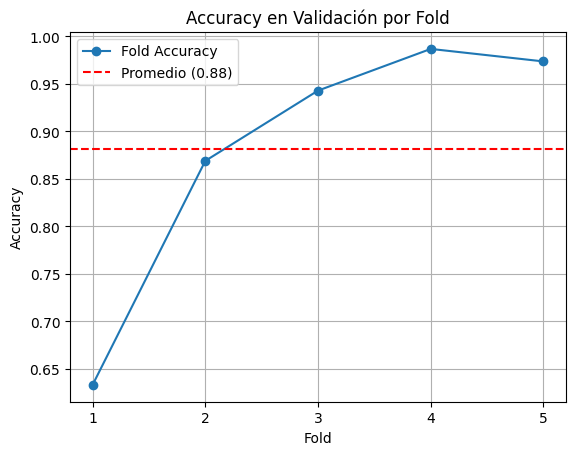

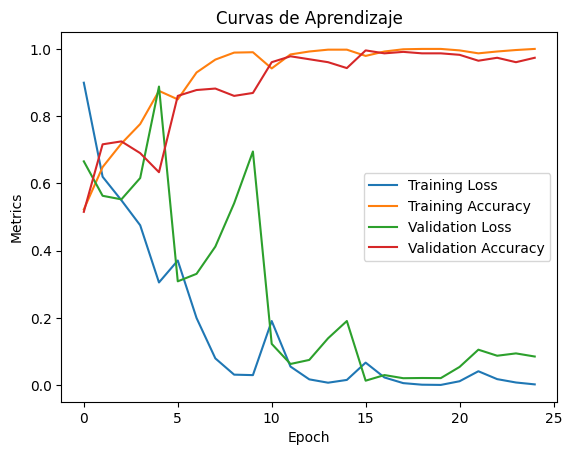

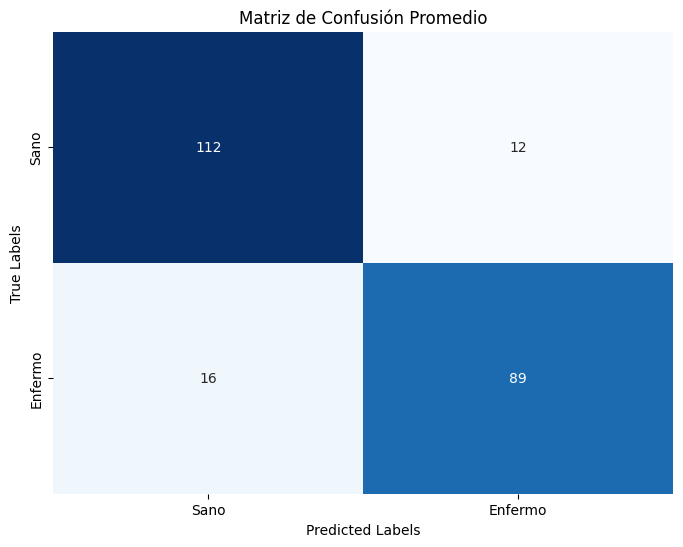

In [121]:
from sklearn.model_selection import KFold
import librosa
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LayerNormalization, LeakyReLU
from sklearn.model_selection import train_test_split
import librosa
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Definir la arquitectura del modelo
class SincConv1D(tf.keras.layers.Layer):
    def __init__(self, N_filt, Filt_dim, fs, stride, padding):
        super(SincConv1D, self).__init__()
        self.N_filt = N_filt
        self.Filt_dim = Filt_dim
        self.fs = fs
        self.stride = stride
        self.padding = padding

    def build(self, input_shape):
        low_freq_mel = 80
        high_freq_mel = (2595 * np.log10(1 + (self.fs / 2) / 700))  # Convertir Hz a Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, self.N_filt)  # Equidistancia en Mel
        f_cos = (700 * (10**(mel_points / 2595) - 1))  # Convertir Mel a Hz
        self.Filt_Bank = np.zeros((self.N_filt, self.Filt_dim))
        self.fs = self.fs

        n = np.linspace(0, self.Filt_dim, num=self.Filt_dim)
        for i in range(self.N_filt):
            self.Filt_Bank[i] = np.sinc(2 * f_cos[i] * (n - (self.Filt_dim - 1) / 2))

        self.Filt_Bank = np.transpose(self.Filt_Bank)

        # Convertir a un tensor de peso para que pueda ser utilizado en la convolución
        self.Filt_Bank = tf.Variable(initial_value=tf.convert_to_tensor(self.Filt_Bank[:, None, :], dtype=tf.float32),
                                     trainable=False)

    def call(self, inputs):
        self.filters = self.Filt_Bank
        output = tf.nn.conv1d(inputs, filters=self.filters, stride=self.stride, padding=self.padding)
        return output

out_dim = 2  # Número de clases

sinc_layer = SincConv1D(N_filt=32, Filt_dim=64, fs=50000, stride=16, padding="SAME")#stride=16, nfilt=64 filt_dim=129

inputs = Input((75000, 1))
x = sinc_layer(inputs)
x = LayerNormalization()(x)

x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size=2)(x)



# Definir el modelo
x = Flatten()(x)
x = Dense(256)(x)
x = LayerNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Dense(256)(x)
x = LayerNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

output = Dense(out_dim, activation='softmax')(x)

model = tf.keras.Model(inputs, output)

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Cargar datos de audio y etiquetas
def load_audio_data(directory, label, target_duration=1.5, sr=50000):
    audio_data = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            try:
                audio, _ = librosa.load(filepath, sr=sr)  # Cargar el archivo de audio con la tasa de muestreo especificada
                # Ajustar la longitud del audio a la duración objetivo
                target_length = int(target_duration * sr)
                if len(audio) < target_length:
                    # Si el audio es más corto que el objetivo, rellenamos con ceros
                    audio = np.pad(audio, (0, target_length - len(audio)), 'constant')
                elif len(audio) > target_length:
                    # Si el audio es más largo que el objetivo, truncamos
                    audio = audio[:target_length]

                audio_data.append(audio)
                labels.append(label)
            except Exception as e:
                print(f"Error al cargar {filepath}: {e}")
    return audio_data, labels

# Cargar datos de audio para personas sanas y enfermas
healthy_audio_data, healthy_labels = load_audio_data("//content/drive/MyDrive/PROYECTO_FINAL/Frases_sanos_hm/export", label=0)
sick_audio_data, sick_labels = load_audio_data("/content/drive/MyDrive/PROYECTO_FINAL/multipatologias_originales/disphonia/export", label=1)

# Concatenar datos de audio y etiquetas
audio_data = np.concatenate([healthy_audio_data, sick_audio_data])
labels = np.concatenate([healthy_labels, sick_labels])

# Convertir a numpy arrays
audio_data = np.array(audio_data)
labels = np.array(labels)

# Inicializar listas para almacenar curvas de aprendizaje
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies_foldwise = []
val_recalls = []
val_f1_scores = []
conf_matrices = []

# Dividir los datos en conjuntos de entrenamiento y prueba
kf = KFold(n_splits=5, shuffle=True)
val_accuracies = []

for i, (train_index, test_index) in enumerate(kf.split(audio_data), 1):
    print(f'Entrenando fold {i}...')
    X_train, X_test = audio_data[train_index], audio_data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Formatear los datos para que coincidan con el formato de entrada del modelo
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Entrenar el modelo
    history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test), verbose=0)

    # Evaluar el modelo en el conjunto de prueba
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Accuracy final en el conjunto de prueba del fold {i}: {accuracy}')

    # Predecir las etiquetas en el conjunto de prueba
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Calcular Recall y F1-score
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

     # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)
    #print("Matriz de Confusión:")
    #print(conf_matrix)

    # Almacenar métricas para análisis
    val_accuracies.append(accuracy)
    train_losses.extend(history.history['loss'])
    train_accuracies.extend(history.history['accuracy'])
    val_losses.extend(history.history['val_loss'])
    val_accuracies_foldwise.extend(history.history['val_accuracy'])
    val_recalls.append(recall)
    val_f1_scores.append(f1)

# Calcular el promedio de las métricas
mean_val_accuracy = np.mean(val_accuracies)
mean_val_recall = np.mean(val_recalls)
mean_val_f1_score = np.mean(val_f1_scores)

print(f'Precision promedio en validación: {mean_val_accuracy}')
print(f'Recall promedio en validación: {mean_val_recall}')
print(f'F1-score promedio en validación: {mean_val_f1_score}')

# Gráfico de la precisión de validación por fold
plt.plot(range(1, kf.get_n_splits() + 1), val_accuracies, marker='o', label='Fold Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy en Validación por Fold')
plt.xticks(range(1, kf.get_n_splits() + 1))
plt.axhline(y=mean_val_accuracy, color='r', linestyle='--', label=f'Promedio ({mean_val_accuracy:.2f})')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de las curvas de aprendizaje
plt.plot(train_losses, label='Training Loss')
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_losses, label='Validation Loss')
plt.plot(val_accuracies_foldwise, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Curvas de Aprendizaje')
plt.legend()
plt.show()

# Matriz de confusión promedio
# Definir los nombres de las clases
class_names = ['Sano', 'Enfermo']
mean_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Matriz de Confusión Promedio")
plt.show()

In [118]:
# Cargar el nuevo audio
new_audio_path = "/content/drive/MyDrive/PROYECTO_FINAL/Frases_sanos_hm/prueba/104-phrase.wav"
new_audio, _ = librosa.load(new_audio_path, sr=50000)

# Ajustar la longitud del audio (si es necesario)
target_duration = 1.5
target_length = int(target_duration * 50000)
if len(new_audio) < target_length:
    new_audio = np.pad(new_audio, (0, target_length - len(new_audio)), 'constant')
elif len(new_audio) > target_length:
    new_audio = new_audio[:target_length]

# Formatear el audio para que coincida con el formato de entrada del modelo
new_audio_input = new_audio[np.newaxis, ..., np.newaxis]

# Realizar la predicción con el modelo
predicted_class = np.argmax(model.predict(new_audio_input))

# Interpretar los resultados
if predicted_class == 0:
    print("El nuevo audio es clasificado como sano.")
elif predicted_class == 1:
    print("El nuevo audio es clasificado como enfermo.")

1/1 [==============================] - 0s 41ms/step
El nuevo audio es clasificado como enfermo.
